In [3]:
import tensorflow as tf
import numpy as np

In [4]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
    
  print("*****\n\n\n******")
  print(features)
  print(features['x'])
  print(labels)
    
    
    
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2 and Pooling Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Dense Layer
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
  logits = tf.layers.dense(inputs=dropout, units=10)
  print("***********\n\n\n\n***********")
  print("logits")
  print(logits.shape)
  print(logits)
    
  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [5]:
  # Load training and eval data
  mnist = tf.contrib.learn.datasets.load_dataset("mnist")
  train_data = mnist.train.images # Returns np.array
  train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
  eval_data = mnist.test.images # Returns np.array
  eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [39]:
print(train_data.shape)

print(train_labels.shape)
print(type(train_labels))

(55000, 784)
(55000,)
<class 'numpy.ndarray'>


In [40]:
# train_data = train_data[0]
# train_labels = train_labels[0]

In [41]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/mnist_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x129d59be0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [42]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [43]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=1,
    num_epochs=None,
    shuffle=True)
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=201,
    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
*****


******
{'x': <tf.Tensor 'random_shuffle_queue_DequeueMany:1' shape=(1, 784) dtype=float32>}
Tensor("random_shuffle_queue_DequeueMany:1", shape=(1, 784), dtype=float32, device=/device:CPU:0)
Tensor("random_shuffle_queue_DequeueMany:2", shape=(1,), dtype=int32, device=/device:CPU:0)
***********



***********
logits
(1, 10)
Tensor("dense_1/BiasAdd:0", shape=(1, 10), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model/model.ckpt-404
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 405 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.10550659 0.0963313  0.10458973 0.0938235  0.09915711 0.0876314
  0.11030205 0.09981412 0.10276828 0.10007599]]
INFO:tensorflow:loss = 2.2752786, step = 405
INFO:tensorflo

In [7]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-15-08:22:20
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model/model.ckpt-203
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-15-08:22:27
INFO:tensorflow:Saving dict for global step 203: accuracy = 0.2576, global_step = 203, loss = 2.2581801
{'accuracy': 0.2576, 'loss': 2.2581801, 'global_step': 203}


In [7]:
import nrrd
import numpy as np
from utils import imshow

# readdata, header = nrrd.read('../data/1241031155/9.40CHESTSegmentation.seg.nrrd')
labeldata_load, header = nrrd.read('../data/1241031155/9.40CHESTSegmentation-label.nrrd')
image_load, header2 = nrrd.read('../data/1241031155/9.40CHESTABDPELVIS.nrrd')

(512, 512, 265)
(265, 512, 512)


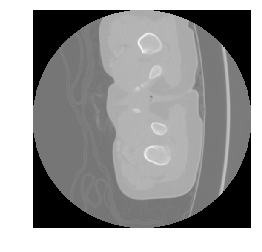

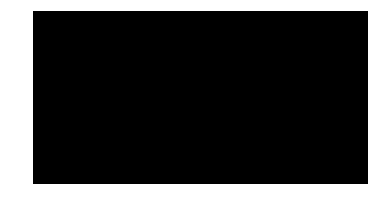

In [33]:
image = image_load
labeldata = labeldata_load

labeldata = np.swapaxes(labeldata, 0, 2)

print(image.shape)
print(labeldata.shape)
imshow(image)
imshow(labeldata)

In [34]:
lbl_arr = np.zeros(265)
for idx, lbl_slice in enumerate(labeldata):
#     print(idx, np.any(lbl_slice))
    lbl_arr[idx] = int(np.any(lbl_slice))

In [35]:
# for idx, n in enumerate(lbl_arr):
#     print(idx, n)
    
print(lbl_arr.shape)
print(type(lbl_arr))

(265,)
<class 'numpy.ndarray'>


In [41]:
image = image.reshape(-1, image.shape[-1])
image = np.swapaxes(image, 0, 1)

print(image.shape)
print(lbl_arr.shape)


(265, 262144)
(265,)


In [37]:
image = np.swapaxes(image, 0, 2)
labeldata = np.swapaxes(labeldata, 0, 2)
print(image.shape)
print(labeldata.shape)

ValueError: bad axis2 argument to swapaxes

In [ ]:
#todo: adapt existing cnn creation function for neuroblastoma data

In [9]:
print(labeldata)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
